# Dissecting Spotify Valence

In this assignment we will dissect Spotify's Valence metric.

---

> Chalkiopoulos Georgios, Electrical and Computer Engineer NTUA <br />
> Data Science postgraduate Student <br />
> gchalkiopoulos@aueb.gr

Spotify uses a metric called *valence* to measure the happiness of a track. The metric itself, however, was not developed by Spotify. It was originally developed by Echo Nest, a company that was bought by Spotify in 2014. We don't know exactly how valence is calculated. Some details are given by a blog post, which you can find here:

https://web.archive.org/web/20170422195736/http://blog.echonest.com/post/66097438564/plotting-musics-emotional-valence-1950-2013

Our task is to untangle the mystery behind valence and propose how this is derived.

Spotify offers the following information, relevant to our task:

* [Get Track's Audio Features](https://developer.spotify.com/documentation/web-api/reference/#/operations/get-audio-features) and [Get Tracks' Audio Features](https://developer.spotify.com/documentation/web-api/reference/#/operations/get-several-audio-features).

* [Get Track's Audio Analysis](https://developer.spotify.com/documentation/web-api/reference/#/operations/get-audio-analysis).


### Setting up the Spotify API*

\* The section in this part uses code from the Course "Practical Data Science" performed in the MSc Data Science program at AUEB by prof. Panos Louridas

In [52]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import statsmodels.api as sm
import statsmodels.formula.api as smf

import glob
import re
from datetime import datetime
import time
import os
import itertools
from itertools import combinations

import spotipy
from spotipy.oauth2 import SpotifyClientCredentials

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler

%matplotlib inline

#### Download the top-streaming songs of the 2017-2019 period

We would like to explore the top-streaming apps in Spotify around the world which are provided by Spotify Charts.

Unfortunately, although the data are downloadble in CVS format, we cannot scrape them as access to them is guarded by CloudFare. Fortunately, data for some countries and the world as a whole, for the period 2017-2019, is available in Zenodo https://doi.org/10.5281/zenodo.4778562 :

  * Gabriel P. Oliveira, Mariana O. Silva, Danilo B. Seufitelli, Anisio Lacerda, and Mirella M. Moro. Detecting Collaboration Profiles in Success-based Music Genre Networks. In Proceedings of the 21st International Society for Music Information Retrieval Conference (ISMIR 2020), 2020.
We'll download the charts data (charts.zip).

After downloading it places data for each region in per-year directories. In each one of these, charts are given in weekly files, so we'll read all for them and record the week and region.

In [3]:
header = 0
dfs = []
for file in glob.glob('../Charts/*/201?/*.csv'):
    region = file.split('/')[1]
    dates = re.findall('\d{4}-\d{2}-\d{2}', file.split('/')[-1])
    weekly_chart = pd.read_csv(file, header=header, sep='\t')
    weekly_chart['week_start'] = datetime.strptime(dates[0], '%Y-%m-%d')
    weekly_chart['week_end'] = datetime.strptime(dates[1], '%Y-%m-%d')
    weekly_chart['region'] = region
    dfs.append(weekly_chart)

all_charts = pd.concat(dfs)
all_charts

,position,song_id,song_name,artist,streams,last_week_position,weeks_on_chart,peak_position,position_status,week_start,week_end,region
0,1,5aAx2yezTd8zXrkmtKl66Z,Starboy,The Weeknd,947261,NaN,1,1,new,2016-12-30,2017-01-06,Charts\au\2017\au-weekly_with_features-2016-12...
1,2,5knuzwU65gJK7IF5yJsuaW,Rockabye (feat. Sean Paul & Anne-Marie),Clean Bandit,893107,NaN,1,2,new,2016-12-30,2017-01-06,Charts\au\2017\au-weekly_with_features-2016-12...
2,3,7BKLCZ1jbUBVqRi2FVlTVw,Closer,The Chainsmokers,871617,NaN,1,3,new,2016-12-30,2017-01-06,Charts\au\2017\au-weekly_with_features-2016-12...
3,4,3NdDpSvN911VPGivFlV5d0,I Don’t Wanna Live Forever (Fifty Shades Darke...,ZAYN,791592,NaN,1,4,new,2016-12-30,2017-01-06,Charts\au\2017\au-weekly_with_features-2016-12...
4,5,78rIJddV4X0HkNAInEcYde,Call On Me - Ryan Riback Extended Remix,Starley,743490,NaN,1,5,new,2016-12-30,2017-01-06,Charts\au\2017\au-weekly_with_features-2016-12...
...,...,...,...,...,...,...,...,...,...,...,...,...
195,196,7f5trao56t7sB7f14QDTmp,Juicy,Doja Cat,1920454,146.0,8,66,-50,2019-12-20,2019-12-27,Charts\us\2019\us-weekly_with_features-2019-12...
196,197,5JiH89mHrv9oWHlD0T326z,To Be So Lonely,Harry Styles,1912267,32.0,2,32,-165,2019-12-20,2019-12-27,Charts\us\2019\us-weekly_with_features-2019-12...
197,198,7GX5flRQZVHRAGd6B4TmDO,XO Tour Llif3,Lil Uzi Vert,1902239,154.0,121,2,-44,2019-12-20,2019-12-27,Charts\us\2019\us-weekly_with_features-2019-12...
198,199,2dpaYNEQHiRxtZbfNsse99,Happier,Marshmello,1899623,173.0,71,8,-26,2019-12-20,2019-12-27,Charts\us\2019\us-weekly_with_features-2019-12...


* There are tens of thousands of songs in the charts, but not all of them are unique:

In [4]:
len(all_charts['song_id'].unique())

13880

* For storing our credentials, we'll create a file spotify_config.py with the following contents:

In [5]:
config = {
    'client_id' : 'XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX',
    'client_secret' :'XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX'
}

* Then we can create a Spotify client.

In [6]:
from spotify_config import config

client_credentials_manager = SpotifyClientCredentials(config['client_id'],
                                                      config['client_secret'])
sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)

* Download the tracks in batches of 100 (limit for free user) and add them a a dict named features.

In [8]:
features = {}
all_track_ids = list(all_charts['song_id'].unique())

start = 0
num_tracks = 100
while start < len(all_track_ids):
    print(f'getting from {start} to {start+num_tracks}')
    tracks_batch = all_track_ids[start:start+num_tracks]
    features_batch = sp.audio_features(tracks_batch)
    features.update({ track_id : track_features 
                     for track_id, track_features in zip(tracks_batch, features_batch) })
    start += num_tracks

getting from 0 to 100
getting from 100 to 200
getting from 200 to 300
getting from 300 to 400
getting from 400 to 500
getting from 500 to 600
getting from 600 to 700
getting from 700 to 800
getting from 800 to 900
getting from 900 to 1000
getting from 1000 to 1100
getting from 1100 to 1200
getting from 1200 to 1300
getting from 1300 to 1400
getting from 1400 to 1500
getting from 1500 to 1600
getting from 1600 to 1700
getting from 1700 to 1800
getting from 1800 to 1900
getting from 1900 to 2000
getting from 2000 to 2100
getting from 2100 to 2200
getting from 2200 to 2300
getting from 2300 to 2400
getting from 2400 to 2500
getting from 2500 to 2600
getting from 2600 to 2700
getting from 2700 to 2800
getting from 2800 to 2900
getting from 2900 to 3000
getting from 3000 to 3100
getting from 3100 to 3200
getting from 3200 to 3300
getting from 3300 to 3400
getting from 3400 to 3500
getting from 3500 to 3600
getting from 3600 to 3700
getting from 3700 to 3800
getting from 3800 to 3900
getting

* Let's verify that we got all of them and see how one looks.

In [9]:
len(features)

13880

In [10]:
features['7qiZfU4dY1lWllzX7mPBI3']

{'danceability': 0.825,
 'energy': 0.652,
 'key': 1,
 'loudness': -3.183,
 'mode': 0,
 'speechiness': 0.0802,
 'acousticness': 0.581,
 'instrumentalness': 0,
 'liveness': 0.0931,
 'valence': 0.931,
 'tempo': 95.977,
 'type': 'audio_features',
 'id': '7qiZfU4dY1lWllzX7mPBI3',
 'uri': 'spotify:track:7qiZfU4dY1lWllzX7mPBI3',
 'track_href': 'https://api.spotify.com/v1/tracks/7qiZfU4dY1lWllzX7mPBI3',
 'analysis_url': 'https://api.spotify.com/v1/audio-analysis/7qiZfU4dY1lWllzX7mPBI3',
 'duration_ms': 233713,
 'time_signature': 4}

* Spotify also offers the [Get Track's Audio Analysis](https://developer.spotify.com/documentation/web-api/reference/#/operations/get-audio-analysis) API. In order to see if there is any usefull info, we looked through the response example and concluded that the `track` part of the response might have some usefull info. Let's see what parts of the track are not available in the `audio_features` API

In [11]:
for key in sp.audio_analysis('5aAx2yezTd8zXrkmtKl66Z')['track']:
    if key not in features['5aAx2yezTd8zXrkmtKl66Z'].keys():
        print(key)

num_samples
duration
sample_md5
offset_seconds
window_seconds
analysis_sample_rate
analysis_channels
end_of_fade_in
start_of_fade_out
tempo_confidence
time_signature_confidence
key_confidence
mode_confidence
codestring
code_version
echoprintstring
echoprint_version
synchstring
synch_version
rhythmstring
rhythm_version


* Based on the columns available we will skip the `audio_features` for now since it seems that the info is not usefull for our analysis.

# Section 1: Expore which Track Features Influence Valence

We will use inferential statistic methods to study how track features influence valence. We will find the best possible model for explaining the valence based on the features that we find significant.

* We'll turn the dictionary to a DataFrame.

In [12]:
# create df, reset index (since the song id is currently index) and rename to song_id
try:
    df = pd.DataFrame.from_dict(features, orient='index').reset_index().rename(columns={'index': 'song_id'})
    df.head()
    print('DataFrame created!')
except:
    df = pd.read_csv('./audio_features.csv')
    print('DataFrame loeaded from file.')

DataFrame created!


* save to csv to have it available next time

In [13]:
if os.path.exists('./audio_features.csv'):
    print('File already exists, not saving.')
    pass
else:
    df.to_csv('./audio_features.csv')
    print('Dataframe saved under audio_features.csv')

File already exists, not saving.


* Let's explore the basic data

In [14]:
df.shape

(13880, 19)

* There is no need to fill N/As since there aren't any:

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13880 entries, 0 to 13879
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   song_id           13880 non-null  object 
 1   danceability      13880 non-null  float64
 2   energy            13880 non-null  float64
 3   key               13880 non-null  int64  
 4   loudness          13880 non-null  float64
 5   mode              13880 non-null  int64  
 6   speechiness       13880 non-null  float64
 7   acousticness      13880 non-null  float64
 8   instrumentalness  13880 non-null  float64
 9   liveness          13880 non-null  float64
 10  valence           13880 non-null  float64
 11  tempo             13880 non-null  float64
 12  type              13880 non-null  object 
 13  id                13880 non-null  object 
 14  uri               13880 non-null  object 
 15  track_href        13880 non-null  object 
 16  analysis_url      13880 non-null  object

* We don't need the id columns, and the uri/l columns so we will drop those:

In [16]:
df.drop(['song_id', 'id', 'track_href', 'analysis_url', 'type'], axis=1, inplace=True)

In [17]:
#  Move dependent variable to the end to make if more pythonic
order = ['danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 
        'liveness', 'tempo', 'duration_ms', 'key', 'mode', 'time_signature', 'valence']
df = df[order]
df.head(3)

,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,tempo,duration_ms,key,mode,time_signature,valence
0,0.681,0.594,-7.028,0.2820,0.165,0.000003,0.134,186.054,230453,7,1,4,0.535
1,0.720,0.763,-4.068,0.0523,0.406,0.000000,0.180,101.965,251088,9,0,4,0.742
2,0.748,0.524,-5.599,0.0338,0.414,0.000000,0.111,95.010,244960,8,1,4,0.661


In [18]:
df.describe()

,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,tempo,duration_ms,key,mode,time_signature,valence
count,13880.000000,13880.000000,13880.000000,13880.000000,13880.000000,13880.000000,13880.000000,13880.000000,1.388000e+04,13880.000000,13880.000000,13880.000000,13880.000000
mean,0.687500,0.665706,-6.299133,0.153766,0.248972,0.007918,0.182294,122.342548,2.072195e+05,5.353963,0.528818,3.979035,0.503584
std,0.141402,0.161337,2.395777,0.130939,0.232291,0.060413,0.153278,28.106891,5.011246e+04,3.636166,0.499187,0.299734,0.214518
min,0.118000,0.005430,-34.475000,0.023100,0.000003,0.000000,0.019700,46.489000,3.040000e+04,0.000000,0.000000,1.000000,0.035400
25%,0.598000,0.566000,-7.474250,0.050100,0.058800,0.000000,0.096000,99.951000,1.776685e+05,2.000000,0.000000,4.000000,0.341000
50%,0.703000,0.680000,-6.016500,0.098300,0.177000,0.000000,0.122000,121.940000,2.012645e+05,6.000000,1.000000,4.000000,0.502000
75%,0.792000,0.784000,-4.751000,0.240000,0.380000,0.000014,0.210000,140.057250,2.286135e+05,8.000000,1.000000,4.000000,0.668000
max,0.980000,0.999000,1.107000,0.966000,0.994000,0.960000,0.990000,212.117000,1.109080e+06,11.000000,1.000000,5.000000,0.982000


Info about the columns: 

* **danceability** number \<float\>: 
  - Danceability describes how suitable a track is for dancing based on a combination of musical elements including tempo, rhythm stability, beat strength, and overall regularity. A value of 0.0 is least danceable and 1.0 is most danceable.
  - \>= 0 <= 1
--- 

* **energy** number \<float\>: 
  * Energy is a measure from 0.0 to 1.0 and represents a perceptual measure of intensity and activity. Typically, energetic tracks feel fast, loud, and noisy. For example, death metal has high energy, while a Bach prelude scores low on the scale. Perceptual features contributing to this attribute include dynamic range, perceived loudness, timbre, onset rate, and general entropy.
  - \>= 0 <= 1
--- 
* **loudness** number \<float\>: 
  * The overall loudness of a track in decibels (dB). Loudness values are averaged across the entire track and are useful for comparing relative loudness of tracks. Loudness is the quality of a sound that is the primary psychological correlate of physical strength (amplitude). Values typically range between -60 and 0 db.
---   
* **mode** integer: 
  * Mode indicates the modality (major or minor) of a track, the type of scale from which its melodic content is derived. Major is represented by 1 and minor is 0.
  - \>= 0 <= 1
---   
* **speechiness** number \<float\>: 
  * Speechiness detects the presence of spoken words in a track. The more exclusively speech-like the recording (e.g. talk show, audio book, poetry), the closer to 1.0 the attribute value. Values above 0.66 describe tracks that are probably made entirely of spoken words. Values between 0.33 and 0.66 describe tracks that may contain both music and speech, either in sections or layered, including such cases as rap music. Values below 0.33 most likely represent music and other non-speech-like tracks.
  - \>= 0 <= 1
---   
* **acousticness** number \<float\>: 
  - A confidence measure from 0.0 to 1.0 of whether the track is acoustic. 1.0 represents high confidence the track is acoustic.
  - \>= 0 <= 1 
---   
* **instrumentalness** number \<float\>: 
  * Predicts whether a track contains no vocals. "Ooh" and "aah" sounds are treated as instrumental in this context. Rap or spoken word tracks are clearly "vocal". The closer the instrumentalness value is to 1.0, the greater likelihood the track contains no vocal content. Values above 0.5 are intended to represent instrumental tracks, but confidence is higher as the value approaches 1.0.
  - \>= 0 <= 1
---   
* **liveness** number \<float\>: 
  * Detects the presence of an audience in the recording. Higher liveness values represent an increased probability that the track was performed live. A value above 0.8 provides strong likelihood that the track is live.
  - \>= 0 <= 1
---   
* **tempo** number \<float\>: 
  * The overall estimated tempo of a track in beats per minute (BPM). In musical terminology, tempo is the speed or pace of a given piece and derives directly from the average beat duration.
---   
* **duration_ms** integer: 
  * The duration of the track in milliseconds.
---   
* **time_signature** integer: 
  - An estimated time signature. The time signature (meter) is a notational convention to specify how many beats are in each bar (or measure). The time signature ranges from 3 to 7 indicating time signatures of "3/4", to "7/4".
  - \>= 3 <= 7
---   
* **valence** number \<float\>: 
  - A measure from 0.0 to 1.0 describing the musical positiveness conveyed by a track. Tracks with high valence sound more positive (e.g. happy, cheerful, euphoric), while tracks with low valence sound more negative (e.g. sad, depressed, angry).
  - \>= 0 <= 1
  


* First we will create histograms for numerical values.

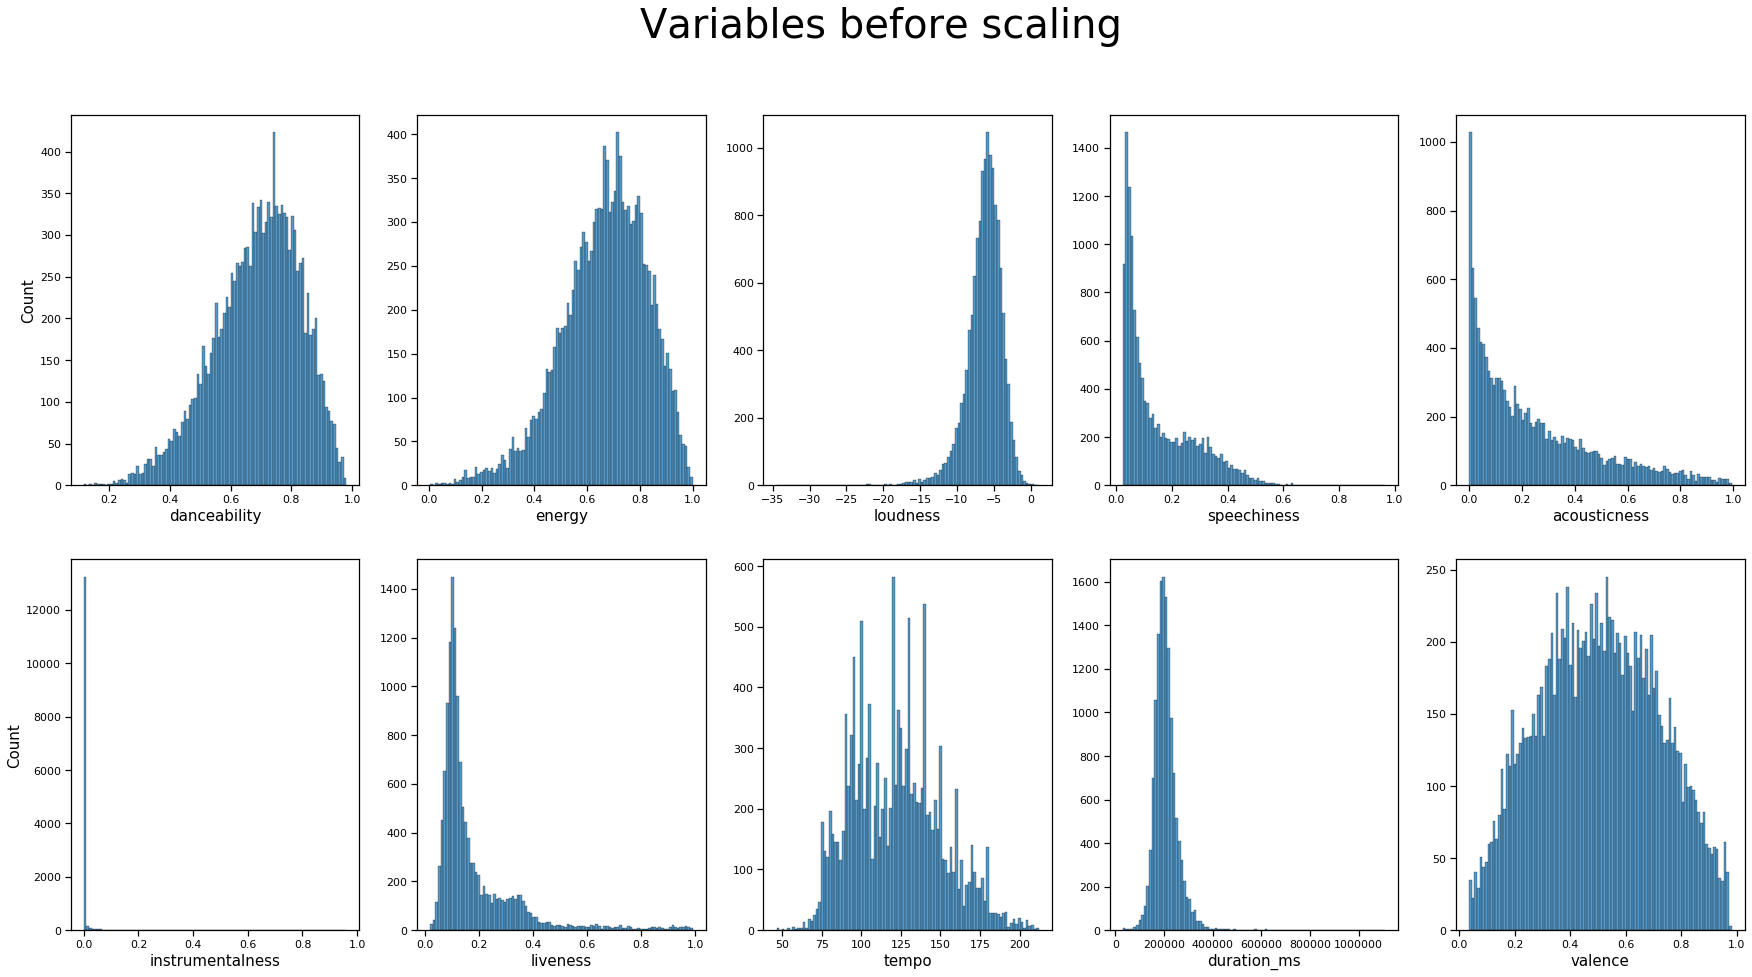

In [19]:
# fix styling
sns.set_context("notebook", rc={"font.size":8,"axes.titlesize":30,"axes.labelsize":15})  

# Create columns iterator
numerical = df.loc[:, ~df.columns.isin(('key',	'mode',	'time_signature'))].columns
lst = iter(numerical)

# Create histograms
fig, axes = plt.subplots(2, 5, figsize=(30, 15))


for triaxis in axes:
    for i, axis in enumerate(triaxis):
        try:
            b = sns.histplot(data = df, x=df[next(lst)], bins = 100, ax=axis)
            if i != 0:
                b.set_ylabel(None)
        except IndexError:
            break

fig.suptitle('Variables before scaling', fontsize=40)

_ = sns.reset_orig        

* Based on the info presented above we need to perform the following pre-poscessing steps:
1. Normalize numeric columns (['Loudness', 'Tempo']) 
2. One hot encode categorical columns* (['Key', 'Time Signature'])

\* 'Mode' is not mentioned since it already takes binary values

In [20]:
# standardize numeric columns by calculating the z-score of each value.
scaler = StandardScaler()
df[['loudness', 'tempo', 'duration_ms']] = scaler.fit_transform(df[['loudness', 'tempo', 'duration_ms']].to_numpy())

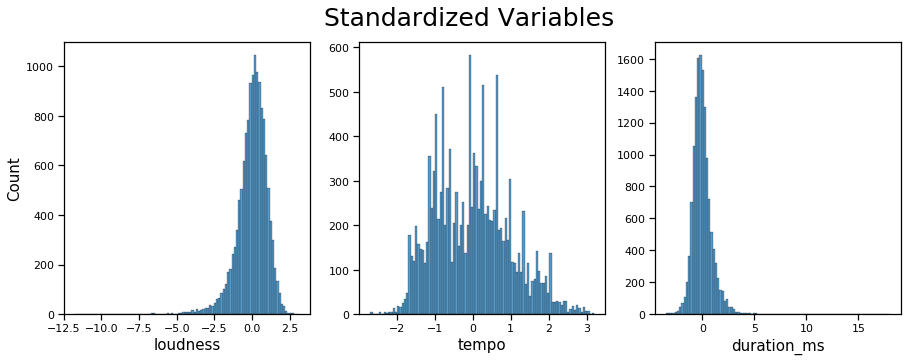

In [21]:
# fix styling
sns.set_context("notebook", rc={"font.size":8,"axes.titlesize":30,"axes.labelsize":15})  

# Create columns iterator
log_numerical = df.loc[:, df.columns.isin(('loudness', 'tempo', 'duration_ms'))].columns
lst = iter(log_numerical)

# Create histograms
fig, axes = plt.subplots(1, 3, figsize=(15, 5))


for i, axis in enumerate(axes):
    try:
        b = sns.histplot(data = df, x=df[next(lst)], bins = 100, ax=axis)
        if i != 0:
            b.set_ylabel(None)
    except IndexError:
        break

fig.suptitle('Standardized Variables', fontsize=25)

_ = sns.reset_orig   

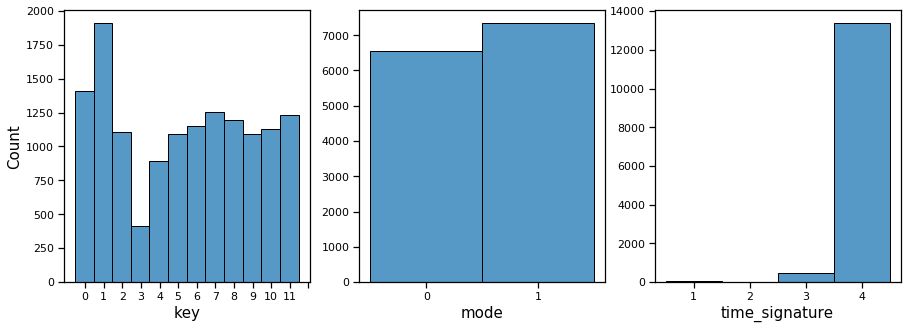

In [22]:
# fix styling
sns.set_context("notebook", rc={"font.size":8,"axes.titlesize":8,"axes.labelsize":15})  

# Create columns iterator
categorical = df.loc[:, df.columns.isin(('key',	'mode',	'time_signature'))].columns
lst = iter(categorical)

# Create histograms
fig, axes = plt.subplots(1, 3, figsize=(15, 5))


for i, axis in enumerate(axes):
    try:
        col = next(lst)
        bin_num = len(df[col].value_counts())
        b = sns.histplot(data = df, x=col, bins=bin_num, ax=axis)
        
        # fix bin position
        if col == 'time_signature':
            
            b.set_xticks(np.arange(df[col].value_counts().keys().min()+0.5,bin_num+1, 1))
            b.set_xticklabels(np.arange(df[col].value_counts().keys().min(),bin_num+1, 1))
        elif col == 'key':
            b.set_xticks(np.arange(df[col].value_counts().keys().min()+0.5,bin_num, 0.915))
            b.set_xticklabels(np.arange(df[col].value_counts().keys().min(),bin_num, 1))
        else:
            b.set_xticks([0.25, 0.75])
            b.set_xticklabels([0,1])
        # keep only one 'count'
        if i != 0:
            b.set_ylabel(None)    
    except IndexError:
        break


_ = sns.reset_orig     

### Run a Linear Regression using statsmodels

* If a categorical variable has $L$ distinct values (or levels), then statsmodels by default creates $L - 1$ *dummy* variables.

In [23]:
# Create the string to feed the regression model
all_columns = list(df.columns[:-4]) + [f"C({col})" for col in df.columns[-4:-1]]
all_columns_formula = f"valence ~ " + '+'.join(all_columns)

# run the regression and print the summary
df_mod = smf.ols(all_columns_formula, data=df)
df_res = df_mod.fit()
df_res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                valence   R-squared:                       0.242
Model:                            OLS   Adj. R-squared:                  0.241
Method:                 Least Squares   F-statistic:                     184.4
Date:                Sun, 02 Jan 2022   Prob (F-statistic):               0.00
Time:                        18:17:48   Log-Likelihood:                 3596.1
No. Observations:               13880   AIC:                            -7142.
Df Residuals:                   13855   BIC:                            -6954.
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                 -0.1886      0.029     -6.433      0.000      -0.246      -0.131
C(key)[T.1]               -0.0252      0.007     -3.808      0.000      -0.038      -0.012
C(key)[T.2]               -0.0164      0.008     -2.181      0.029      -0.031      -0.002
C(key)[T.3]                0.0435      0.010      4.152      0.000       0.023       0.064
C(key)[T.4]               -0.0325      0.008     -4.027      0.000      -0.048      -0.017
C(key)[T.5]                0.0170      0.008      2.230      0.026       0.002       0.032
C(key)[T.6]                0.0131      0.007      1.751      0.080      -0.002       0.028
C(key)[T.7]               -0.0017      0.007     -0.231      0.818      -0.016       0.013
C(key)[T.8]                0.0042      0.007      0.567      0.570      -0.010       0.019
C(key)[T.9]                0.0040      0.008      0.526      0.599      -0.011       0.019
C(key)[T.10]              -0.0047      0.008     -0.623      0.533      -0.020       0.010
C(key)[T.11]               0.0182      0.007      2.468      0.014       0.004       0.033
C(mode)[T.1]               0.0072      0.003      2.126      0.034       0.001       0.014
C(time_signature)[T.3]    -0.0170      0.027     -0.623      0.533      -0.070       0.036
C(time_signature)[T.4]    -0.0321      0.026     -1.237      0.216      -0.083       0.019
C(time_signature)[T.5]     0.0052      0.028      0.188      0.851      -0.049       0.060
danceability               0.4152      0.012     33.472      0.000       0.391       0.440
energy                     0.6045      0.015     39.585      0.000       0.575       0.634
loudness                  -0.0056      0.002     -2.334      0.020      -0.010      -0.001
speechiness               -0.1178      0.013     -9.191      0.000      -0.143      -0.093
acousticness               0.1706      0.008     22.070      0.000       0.155       0.186
instrumentalness          -0.1606      0.027     -6.018      0.000      -0.213      -0.108
liveness                   0.0515      0.011      4.800      0.000       0.030       0.072
tempo                      0.0067      0.002      4.162      0.000       0.004       0.010
duration_ms               -0.0141      0.002     -8.602      0.000      -0.017      -0.011
==============================================================================
Omnibus:                      137.347   Durbin-Watson:                   1.842
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               88.008
Skew:                           0.013   Prob(JB):                     7.75e-20
Kurtosis:                       2.611   Cond. No.                         60.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance mat

### One hot encode (Using sklearn)

* It seems that some keys/time signatures could be excluded for the model, based on the p-values, which are higher than the typical significance levels (5%, 1%, 0,1%). It is worth noting here than the p-value signifies the minimum value in which the Null hypothesis (that the coefficients fo not play a significant role) is rejected. In order to verify that the 


* We will now proceed with one-hot encoding the categorical variables, since we want to exclude some of them. The originl dataframe (df) will be kept intact, since the one hot encoding we will prerform here will be different than the one needed for the ML part (prediction), and we will use a df_dummy for this part of the analysis.
* Note that `drop_first` is used here, since that is the standard when doing a statistical analysis.

In [24]:
df_dummy = pd.get_dummies(df, columns=['key', 'mode', 'time_signature'], drop_first=True)

# Move valence column to the end
order = list(df_dummy.columns)
order.remove('valence')
order.append('valence')

# Re-order
df_dummy = df_dummy[order]

df_dummy.head()

,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,tempo,duration_ms,key_1,...,key_7,key_8,key_9,key_10,key_11,mode_1,time_signature_3,time_signature_4,time_signature_5,valence
0,0.681,0.594,-0.304241,0.2820,0.1650,0.000003,0.134,2.266837,0.463644,0,...,1,0,0,0,0,1,0,1,0,0.5350
1,0.720,0.763,0.931311,0.0523,0.4060,0.000000,0.180,-0.725028,0.875433,0,...,0,0,1,0,0,0,0,1,0,0.7420
2,0.748,0.524,0.292247,0.0338,0.4140,0.000000,0.111,-0.972485,0.753143,0,...,0,1,0,0,0,1,0,1,0,0.6610
3,0.735,0.451,-0.866083,0.0585,0.0631,0.000013,0.325,-0.155467,0.757933,0,...,0,0,0,0,0,1,0,1,0,0.0862
4,0.670,0.838,0.946755,0.0362,0.0604,0.000611,0.159,-0.617115,0.295775,0,...,0,0,0,0,0,1,0,1,0,0.7170


* Let's run again the regression having created the dummy variables with sklearn, to verify we get the same results as the statsmodel default dummy variables way.

In [25]:
# repeat the porcess with the new dataframe to verify results
all_columns = list(df_dummy.columns[:-1])

# run the regression and print the summary
all_columns_formula = f"valence ~ " + '+'.join(all_columns)
df_dummy_mod_full = smf.ols(all_columns_formula, data=df_dummy)
df_dummy_res_full = df_dummy_mod_full.fit()
df_dummy_res_full.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                valence   R-squared:                       0.242
Model:                            OLS   Adj. R-squared:                  0.241
Method:                 Least Squares   F-statistic:                     184.4
Date:                Sun, 02 Jan 2022   Prob (F-statistic):               0.00
Time:                        18:17:48   Log-Likelihood:                 3596.1
No. Observations:               13880   AIC:                            -7142.
Df Residuals:                   13855   BIC:                            -6954.
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           -0.1886      0.029     -6.433      0.000      -0.246      -0.131
danceability         0.4152      0.012     33.472      0.000       0.391       0.440
energy               0.6045      0.015     39.585      0.000       0.575       0.634
loudness            -0.0056      0.002     -2.334      0.020      -0.010      -0.001
speechiness         -0.1178      0.013     -9.191      0.000      -0.143      -0.093
acousticness         0.1706      0.008     22.070      0.000       0.155       0.186
instrumentalness    -0.1606      0.027     -6.018      0.000      -0.213      -0.108
liveness             0.0515      0.011      4.800      0.000       0.030       0.072
tempo                0.0067      0.002      4.162      0.000       0.004       0.010
duration_ms         -0.0141      0.002     -8.602      0.000      -0.017      -0.011
key_1               -0.0252      0.007     -3.808      0.000      -0.038      -0.012
key_2               -0.0164      0.008     -2.181      0.029      -0.031      -0.002
key_3                0.0435      0.010      4.152      0.000       0.023       0.064
key_4               -0.0325      0.008     -4.027      0.000      -0.048      -0.017
key_5                0.0170      0.008      2.230      0.026       0.002       0.032
key_6                0.0131      0.007      1.751      0.080      -0.002       0.028
key_7               -0.0017      0.007     -0.231      0.818      -0.016       0.013
key_8                0.0042      0.007      0.567      0.570      -0.010       0.019
key_9                0.0040      0.008      0.526      0.599      -0.011       0.019
key_10              -0.0047      0.008     -0.623      0.533      -0.020       0.010
key_11               0.0182      0.007      2.468      0.014       0.004       0.033
mode_1               0.0072      0.003      2.126      0.034       0.001       0.014
time_signature_3    -0.0170      0.027     -0.623      0.533      -0.070       0.036
time_signature_4    -0.0321      0.026     -1.237      0.216      -0.083       0.019
time_signature_5     0.0052      0.028      0.188      0.851      -0.049       0.060
==============================================================================
Omnibus:                      137.347   Durbin-Watson:                   1.842
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               88.008
Skew:                           0.013   Prob(JB):                     7.75e-20
Kurtosis:                       2.611   Cond. No.                         60.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

* The results we hot match the ones we previously had (when statsmodel took care of the dummy variable assigmnent)

* We will now remove the columns with a p-value above the typical significance level of 5% and run the linear regression once more. 

In [26]:
col_reduced = all_columns
col_reduced = [i for i in col_reduced if i not in ['key_7', 'key_8', 'key_9', 'key_10', 'time_signature_3', 'time_signature_4']]

# run the regression and print the summary
col_reduced_formula = f"valence ~ " + '+'.join(col_reduced)
df_dummy_mod = smf.ols(col_reduced_formula, data=df_dummy)
df_dummy_res = df_dummy_mod.fit()
df_dummy_res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                valence   R-squared:                       0.242
Model:                            OLS   Adj. R-squared:                  0.241
Method:                 Least Squares   F-statistic:                     245.6
Date:                Sun, 02 Jan 2022   Prob (F-statistic):               0.00
Time:                        18:17:48   Log-Likelihood:                 3593.1
No. Observations:               13880   AIC:                            -7148.
Df Residuals:                   13861   BIC:                            -7005.
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           -0.2154      0.015    -14.667      0.000      -0.244      -0.187
danceability         0.4097      0.012     33.835      0.000       0.386       0.433
energy               0.6030      0.015     39.565      0.000       0.573       0.633
loudness            -0.0057      0.002     -2.378      0.017      -0.010      -0.001
speechiness         -0.1165      0.013     -9.111      0.000      -0.142      -0.091
acousticness         0.1715      0.008     22.238      0.000       0.156       0.187
instrumentalness    -0.1592      0.027     -5.970      0.000      -0.212      -0.107
liveness             0.0507      0.011      4.733      0.000       0.030       0.072
tempo                0.0066      0.002      4.136      0.000       0.003       0.010
duration_ms         -0.0142      0.002     -8.666      0.000      -0.017      -0.011
key_1               -0.0256      0.005     -5.155      0.000      -0.035      -0.016
key_2               -0.0172      0.006     -2.797      0.005      -0.029      -0.005
key_3                0.0428      0.009      4.505      0.000       0.024       0.061
key_4               -0.0329      0.007     -4.875      0.000      -0.046      -0.020
key_5                0.0166      0.006      2.686      0.007       0.004       0.029
key_6                0.0127      0.006      2.102      0.036       0.001       0.025
key_11               0.0177      0.006      3.007      0.003       0.006       0.029
mode_1               0.0076      0.003      2.275      0.023       0.001       0.014
time_signature_5     0.0356      0.011      3.301      0.001       0.014       0.057
==============================================================================
Omnibus:                      139.082   Durbin-Watson:                   1.842
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               88.897
Skew:                           0.014   Prob(JB):                     4.97e-20
Kurtosis:                       2.609   Cond. No.                         26.1
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### ANOVA

* We can check if the two models fit the data equally well ot if  the reduced model fit is better than the full model fit using ANOVA.

* The null hypothesis is that the two models fit the data equally well, while the alternative hypothesis is that the full model model is superior.

* Based on the p-value, we cannot reject the Null hypothesis, thus we consider the two models to fit the model equally well

In [27]:
table = sm.stats.anova_lm(df_dummy_res, df_dummy_res_full)
table

,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,13861.0,484.241344,0.0,NaN,NaN,NaN
1,13855.0,484.032431,6.0,0.208913,0.996658,0.425488


<br><br>
### Best variable model selection using step-wise methods

* In searching for the "best" possible sub-model in multiple linear regression, one can use stepwise methods, which are algorithmic methods that come with a proposal of the "best" sub-model.
<br/><br/>
* The most popular stepwise methods are:
    - Backward Elimination
    - Forward Selection
    - Stepwise Regression

In [28]:
def plot_model_selection(models, best_model, reverse=False):
    """
    Function that plots the adjusted r-squared based on the number of parameters, 
    also indicating the position of the best found R-squared.
    """
    if reverse:
        models = models[::-1]
    all_rsquared = np.array([ x.rsquared  for x in models ])
    all_rsquared_adj = np.array([ x.rsquared_adj  for x in models ])
    best_indx =len(best_model.model.exog_names)
    print(best_indx)
    x = np.arange(1, len(all_rsquared)+1)

    plt.figure(figsize=(8, 6))
    plt.plot(x, all_rsquared, marker='*', label='$R^2$')
    plt.plot(x, all_rsquared_adj, marker='o', label='Adjusted $R^2$')
    plt.plot(best_indx, all_rsquared_adj[best_indx], marker='x', markersize=14, color='k')
    plt.legend()
    plt.title('$R^2$ vs Adjusted $R^2$', fontsize=20)

def process_subset(y, data, feature_set):
    """
    Function that takes the subset of a model and returns the fitted regression model
    INPUT: dependent variable, the dataframe to process
    """
    X = data.loc[:, feature_set].values
    X = sm.add_constant(X)
    names = ['intercept']
    names.extend(feature_set)
    model = sm.OLS(y, X)
    model.data.xnames = names
    regr = model.fit()
    return regr

### Forward stepwise selection

* We start with picking the best model with one variable.

* We find the best model with two variables by adding one variable.

* We find the best model with three variables by adding another variable, and so on.

* This is *not* guaranteed to find the best model overall.

* We write `forward_add_variable()` to find the best variable to add at each step.

In [29]:
def forward_add_variable(data, exog, selected, to_select):
    best_rsquared = 0
    best_model = None
    best_column = None
    y = data.loc[:, exog]
    
    for column in to_select:
        new_selected = selected + [column]
        regr = process_subset(y, data, new_selected)
        if regr.rsquared > best_rsquared:
            best_rsquared = regr.rsquared
            best_model = regr
            best_column = column
    
    return best_model, best_column

def forward_stepwise_selection(data, exog, printing=False):

    best_models = []
    best_model = None
    selected = []
    to_select = [ x for x in data.columns if x != exog ]

    p = len(to_select) + 1

    for i in range(1, p):
        if printing:
            print(f'Finding the best model for {i} variable{"s" if i > 1 else ""}')
        model, best_column = forward_add_variable(data, exog, selected, to_select)
        selected.append(best_column)
        to_select.remove(best_column)
        if not best_model or model.rsquared_adj > best_model.rsquared_adj:
            best_model = model
        if printing:
            print(selected)
        best_models.append(model)
        
    print(f'Fitted {1 + p*(p+1)//2} models')
    return best_model, best_models

In [30]:
# find the best model with forward selection
best_model_fw, best_models_fw = forward_stepwise_selection(df_dummy, 'valence')
print('Best overall model:', len(best_model_fw.model.exog_names), best_model_fw.model.exog_names)

Fitted 326 models
Best overall model: 20 ['intercept', 'energy', 'danceability', 'acousticness', 'duration_ms', 'speechiness', 'key_1', 'key_4', 'instrumentalness', 'liveness', 'key_3', 'tempo', 'key_2', 'time_signature_4', 'key_11', 'key_5', 'loudness', 'mode_1', 'key_6', 'time_signature_3']


In [31]:
best_model_fw.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                valence   R-squared:                       0.242
Model:                            OLS   Adj. R-squared:                  0.241
Method:                 Least Squares   F-statistic:                     232.9
Date:                Sun, 02 Jan 2022   Prob (F-statistic):               0.00
Time:                        18:17:51   Log-Likelihood:                 3595.2
No. Observations:               13880   AIC:                            -7150.
Df Residuals:                   13860   BIC:                            -7000.
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
intercept           -0.1844      0.017    -11.023      0.000      -0.217      -0.152
energy               0.6047      0.015     39.621      0.000       0.575       0.635
danceability         0.4151      0.012     33.480      0.000       0.391       0.439
acousticness         0.1706      0.008     22.082      0.000       0.155       0.186
duration_ms         -0.0141      0.002     -8.605      0.000      -0.017      -0.011
speechiness         -0.1177      0.013     -9.198      0.000      -0.143      -0.093
key_1               -0.0255      0.005     -5.149      0.000      -0.035      -0.016
key_4               -0.0327      0.007     -4.848      0.000      -0.046      -0.020
instrumentalness    -0.1608      0.027     -6.029      0.000      -0.213      -0.109
liveness             0.0514      0.011      4.793      0.000       0.030       0.072
key_3                0.0432      0.009      4.548      0.000       0.025       0.062
tempo                0.0067      0.002      4.166      0.000       0.004       0.010
key_2               -0.0168      0.006     -2.732      0.006      -0.029      -0.005
time_signature_4    -0.0363      0.010     -3.603      0.000      -0.056      -0.017
key_11               0.0180      0.006      3.057      0.002       0.006       0.029
key_5                0.0167      0.006      2.706      0.007       0.005       0.029
loudness            -0.0056      0.002     -2.342      0.019      -0.010      -0.001
mode_1               0.0077      0.003      2.292      0.022       0.001       0.014
key_6                0.0129      0.006      2.130      0.033       0.001       0.025
time_signature_3    -0.0210      0.013     -1.592      0.111      -0.047       0.005
==============================================================================
Omnibus:                      136.561   Durbin-Watson:                   1.842
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               87.641
Skew:                           0.014   Prob(JB):                     9.31e-20
Kurtosis:                       2.612   Cond. No.                         30.6
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

20


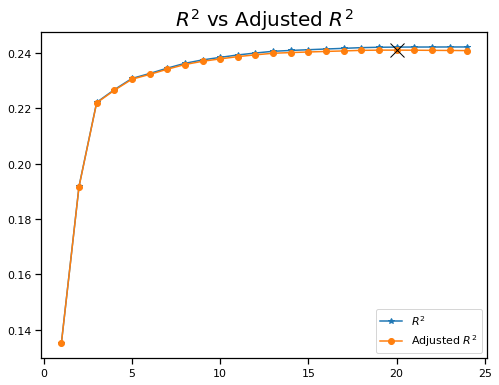

In [32]:
plot_model_selection(best_models_fw, best_model_fw)

### Backward Elimination selection

* Alternatively, if the number of independent variables is large, then we can do *backward stepwise selection*.

* We start with picking the best model with all $p$ variables.

* We find the best model with $p - 1$ variables by removing one variable.

* We find the best model with $p - 2$ variables by removing another variable, and so on.

* Again, this is *not* guaranteed to find the best model overall.

* We write `backward_remove_variable()` to find the best variable to remove at each step.

In [33]:
def backward_remove_variable(data, exog, selected):
    
    best_rsquared = 0
    best_model = None
    best_column = None
    y = data.loc[:, exog]
    
    for column in selected:
        new_selected = selected[:]
        new_selected.remove(column)
        regr = process_subset(y, data, new_selected)
        if regr.rsquared > best_rsquared:
            best_rsquared = regr.rsquared
            best_model = regr
            best_column = column
    
    return best_model, best_column

def backward_stepwise_selection(data, exog, printing=False):

    best_models = []
    selected = [ x for x in data.columns if x != exog ]

    p = len(selected) + 1
    if printing:
        print(f'Finding the best model for {p - 1} variables')
        print(selected)
    y = data.loc[:, exog]
    best_model = process_subset(y, data, selected)
    best_models.append(best_model)

    for i in reversed(range(2, p)):
        if printing:
            print(f'Finding the best model for {i - 1} variable{"s" if (i - 1) > 1 else ""}')
        model, best_column = backward_remove_variable(data, exog, selected)
        selected.remove(best_column)
        if not best_model or model.rsquared_adj > best_model.rsquared_adj:
            best_model = model
        if printing:
            print(selected)
        best_models.append(model)
        
    print(f'Fitted {1 + p*(p+1)//2} models')
    return best_model, best_models    

In [34]:
best_model_bw, best_models_bw = backward_stepwise_selection(df_dummy, 'valence')
print('Best overall model:', len(best_model_bw.model.exog_names), best_model_bw.model.exog_names)

Fitted 326 models
Best overall model: 20 ['intercept', 'danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'tempo', 'duration_ms', 'key_1', 'key_2', 'key_3', 'key_4', 'key_5', 'key_6', 'key_11', 'mode_1', 'time_signature_3', 'time_signature_4']


In [35]:
best_model_bw.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                valence   R-squared:                       0.242
Model:                            OLS   Adj. R-squared:                  0.241
Method:                 Least Squares   F-statistic:                     232.9
Date:                Sun, 02 Jan 2022   Prob (F-statistic):               0.00
Time:                        18:17:57   Log-Likelihood:                 3595.2
No. Observations:               13880   AIC:                            -7150.
Df Residuals:                   13860   BIC:                            -7000.
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
intercept           -0.1844      0.017    -11.023      0.000      -0.217      -0.152
danceability         0.4151      0.012     33.480      0.000       0.391       0.439
energy               0.6047      0.015     39.621      0.000       0.575       0.635
loudness            -0.0056      0.002     -2.342      0.019      -0.010      -0.001
speechiness         -0.1177      0.013     -9.198      0.000      -0.143      -0.093
acousticness         0.1706      0.008     22.082      0.000       0.155       0.186
instrumentalness    -0.1608      0.027     -6.029      0.000      -0.213      -0.109
liveness             0.0514      0.011      4.793      0.000       0.030       0.072
tempo                0.0067      0.002      4.166      0.000       0.004       0.010
duration_ms         -0.0141      0.002     -8.605      0.000      -0.017      -0.011
key_1               -0.0255      0.005     -5.149      0.000      -0.035      -0.016
key_2               -0.0168      0.006     -2.732      0.006      -0.029      -0.005
key_3                0.0432      0.009      4.548      0.000       0.025       0.062
key_4               -0.0327      0.007     -4.848      0.000      -0.046      -0.020
key_5                0.0167      0.006      2.706      0.007       0.005       0.029
key_6                0.0129      0.006      2.130      0.033       0.001       0.025
key_11               0.0180      0.006      3.057      0.002       0.006       0.029
mode_1               0.0077      0.003      2.292      0.022       0.001       0.014
time_signature_3    -0.0210      0.013     -1.592      0.111      -0.047       0.005
time_signature_4    -0.0363      0.010     -3.603      0.000      -0.056      -0.017
==============================================================================
Omnibus:                      136.561   Durbin-Watson:                   1.842
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               87.641
Skew:                           0.014   Prob(JB):                     9.31e-20
Kurtosis:                       2.612   Cond. No.                         30.6
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

20


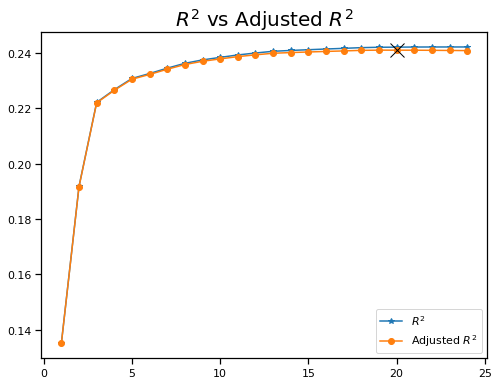

In [36]:
plot_model_selection(best_models_bw, best_model_bw, reverse=True)

### Check results vs AIC, BIC

* Usually in statistics, stepwise regression is performed using AIC. 
* Since we used the Adjusted $R^2$ for our stepwise selection, we will evaludate the results against the AIC. 
* Want we are expecting is the find the best $R^2$ value where the AIC is small.

In [37]:
def plot_model_AIC(models, best_model, reverse=False):
    """
    Function that plots the adjusted r-squared based on the number of parameters, 
    also indicating the position of the best found R-squared.
    """
    if reverse:
        models = models[::-1]
    aic = np.array([ x.aic for x in models ])
    bic = np.array([ x.bic for x in models ])
    all_rsquared_adj = np.array([ x.rsquared_adj  for x in models ])
    best_indx =len(best_model.model.exog_names)
    print(best_indx)
    x = np.arange(1, len(aic)+1)


    fig, ax1 = plt.subplots(figsize=(8, 6))
    ax2 = ax1.twinx()

    ax1.plot(x, aic, marker='*', label='AIC', color = 'red')
    ax1.plot(x, bic, marker='*', label='BIC', color = 'green')
    ax2.plot(x, all_rsquared_adj, marker='o', label='Adjusted $R^2$')
    ax2.plot(best_indx, all_rsquared_adj[best_indx], marker='x', markersize=14, color='k')
    fig.legend(loc='center right',bbox_to_anchor=(0.4, 0.2, 0.47, 0.5))
    plt.title('AIC/BIC vs Adjusted $R^2$', fontsize=20)

* As shown below the AIC is getting smaller as the Adjusted $R^2$ is getting bigger, which means that the stepwise method worked as expected.
* On the other hand the BIC seems to be a little bit higher in the selected $R^2$, but since the parameter selection is performed with either AIC or BIC we will accept the results based on the AIC criterion.

20


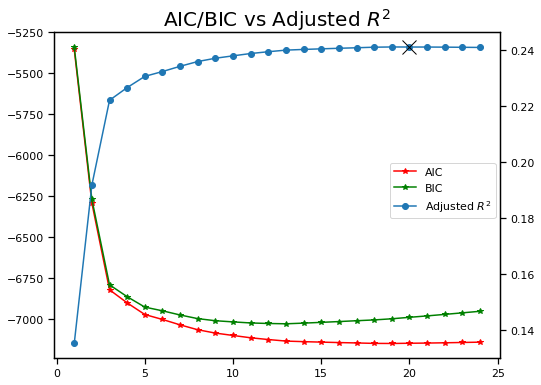

In [38]:
plot_model_AIC(best_models_bw, best_model_bw, reverse=True)

## Section 1 conclusion

| Model        | Adjusted $R^2$ |  AIC        
| ------------- |:--------------:|:--------------:|
| Full model     | 0.241 |  -7142.27 |
| p-value opt     | 0.241       | -7148.28 |
| Forward Selection | 0.241       | -7150.36|
| Backward Elimination | 0.241       | -7150.36|

* We started having the full model with the full model which has the following parameters:

In [39]:
print(f"Full Model: Adjusted R_squared: {df_dummy_res_full.rsquared_adj:.3f}, AIC: {df_dummy_res_full.aic:.2f}", end = '\n\n')
print("Full Model parameters:")
_ = [print(i, end = ', ') for i in sorted(df_dummy_res_full.params.keys())]

Full Model: Adjusted R_squared: 0.241, AIC: -7142.27

Full Model parameters:
Intercept, acousticness, danceability, duration_ms, energy, instrumentalness, key_1, key_10, key_11, key_2, key_3, key_4, key_5, key_6, key_7, key_8, key_9, liveness, loudness, mode_1, speechiness, tempo, time_signature_3, time_signature_4, time_signature_5, 

* We then used three different methods to get better results. 
* The parameters that were removed from the full model, along with the corresponding $R^2$ and AIC  can be found below.

In [40]:

for i, string in zip([df_dummy_res, best_model_fw, best_model_bw], ['Parameters removed using the p-value optimization method:',
                                            "Parameters removed using Forward Selection:", "Parameters removed using Backward Elimination:"]):
    print(string)
    _ = [print(par, end = ', ') for par in sorted(df_dummy_res_full.params.keys()) if par not in i.params.keys() and par != 'Intercept']    
    print(f"\nAdjusted R_squared: {i.rsquared_adj:.3f}, AIC: {i.aic:.2f}")
    print('\n'*2)                                        

Parameters removed using the p-value optimization method:
key_10, key_7, key_8, key_9, time_signature_3, time_signature_4, 
Adjusted R_squared: 0.241, AIC: -7148.28



Parameters removed using Forward Selection:
key_10, key_7, key_8, key_9, time_signature_5, 
Adjusted R_squared: 0.241, AIC: -7150.36



Parameters removed using Backward Elimination:
key_10, key_7, key_8, key_9, time_signature_5, 
Adjusted R_squared: 0.241, AIC: -7150.36





# Section 2: Predict Valence

We will use Machine Learning techniques to predict valence based on track features. Rules:

* Use at least three different methods. For each method, ensure thatthe hyperparameters are tunes to the best result possible.

* Once the best method and hyperparameters are identified, explain, to the extent that is possible, which features influence the valence metric.

* Evaluate predictions on a holdout 20% testing dataset.

In [91]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.cluster import DBSCAN
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler

from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, BatchNormalization
from keras.regularizers import l2
import xgboost as xgb
from xgboost import XGBRegressor

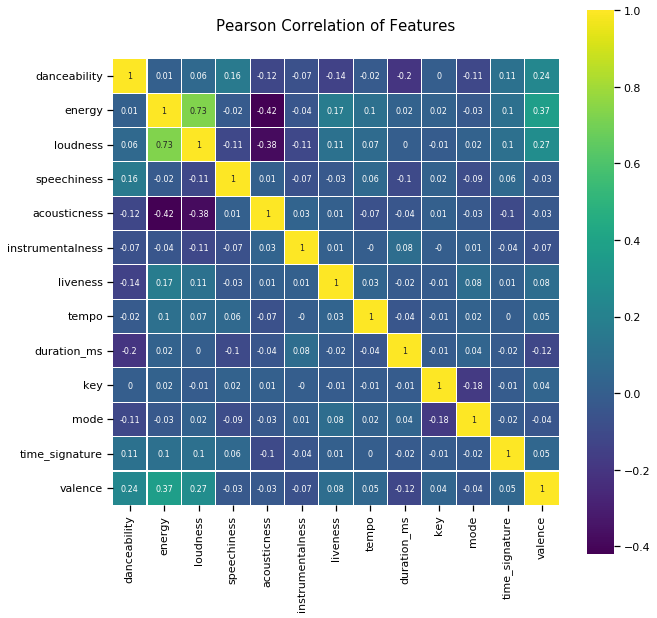

In [41]:
# Show correlation table
def correlation_table(df):
    colormap = plt.cm.viridis
    plt.figure(figsize=(10,10))
    plt.title('Pearson Correlation of Features', y=1.05, size=15)
    sns.heatmap(df.corr().round(2)\
                ,linewidths=0.1,vmax=1.0, square=True, cmap=colormap, \
                linecolor='white', annot=True)

correlation_table(df)

In [42]:
# Plot feature importances
def plot_model_var_imp(model, X):
    imp = pd.DataFrame(model.feature_importances_,
                       columns = ['Importance'],
                       index = X.columns).sort_values(['Importance'], ascending=True)
    imp.plot(kind = 'barh')
    plt.show()

In [92]:
# Fit model (only XGBoost here)
def regression(train_df, LINREG=False, RIDGE=False, LASSO=False, SVMR=False, XGB=True, RF=False, NN=False):
    X = train_df.drop("valence", axis=1)
    Y = train_df.valence
    
    
    np.random.seed(1) # set random seed for reproducibility
    X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2, random_state = 42)
    
    # Linear Regression
    if LINREG:
        st = time.time()
        lin_reg = LinearRegression()
        lin_reg.fit(X_train, Y_train)
        pred_lr = lin_reg.predict(X_val)

        print('Linear Regression RMSE with {0} training data points:'.format(len(X_train)),
              str(np.sqrt(mean_squared_error(pred_lr, Y_val))))
        print('Linear Regression CPU Time:', time.time() - st, 'seconds\n')
    else:
        lin_reg = None
    
    # Ridge Regression
    if RIDGE:
        st = time.time()
        ridge = Ridge(alpha=0.5)
        ridge.fit(X_train, Y_train)
        pred_ridge = ridge.predict(X_val)

        print('Ridge Regression RMSE with {0} training data points:'.format(len(X_train)),
              str(np.sqrt(mean_squared_error(pred_ridge, Y_val))))
        print('Ridge Regression CPU Time:', time.time() - st, 'seconds\n')
    else:
        ridge = None
        
    # Lasso Regression
    if LASSO:
        st = time.time()
        lasso = Lasso(alpha=0.1, max_iter=5000)
        lasso.fit(X_train, Y_train)
        pred_lasso = lasso.predict(X_val)

        print('Lasso Regression RMSE with {0} training data points:'.format(len(X_train)),
              str(np.sqrt(mean_squared_error(pred_lasso, Y_val))))
        print('Lasso Regression CPU Time:', time.time() - st, 'seconds\n')
    else:
        lasso = None
    
    # Support Vector Machines Regressor (non-linear kernel)
    if SVMR:
        st = time.time()
        svr = SVR()
        svr.fit(X_train, Y_train)
        pred_svr = svr.predict(X_val)

        print('Support Vector Regressor RMSE with {0} training data points:'.format(len(X_train)),
              str(np.sqrt(mean_squared_error(pred_svr, Y_val))))
        print('Support Vector Regressor CPU Time:', time.time() - st, 'seconds\n')
    else:
        svr = None
    
    # XGBoost
    if XGB:
        st = time.time()
        xgb = XGBRegressor(max_depth=9, learning_rate=0.045, n_estimators=500, reg_lambda=0.5)
        xgb.fit(X_train, Y_train)
        pred_xgb = xgb.predict(X_val)

        print('XGBoost RMSE with {0} training data points:'.format(len(X_train)),
              str(np.sqrt(mean_squared_error(pred_xgb, Y_val))))
        print('XGBoost CPU Time:', time.time() - st, 'seconds\n')
        plot_model_var_imp(xgb, X_train)
    else:
        xgb = None
    
    # Random Forest
    if RF:
        st = time.time()
        random_forest = RandomForestRegressor(n_estimators=500)
        random_forest.fit(X_train, Y_train)
        pred_rf = random_forest.predict(X_val)

        print('Random Forest RMSE with {0} training data points:'.format(len(X_train)),
              str(np.sqrt(mean_squared_error(pred_rf, Y_val))))
        print('Random Forest CPU Time:', time.time() - st, 'seconds\n')
        plot_model_var_imp(random_forest, X_train)
    else:
        random_forest = None
    
    # Neural Network
    if NN:
        st = time.time()
        NN_model = Sequential()
        NN_model.add(Dense(20, kernel_initializer='normal', input_dim=X_train.shape[1], activation='relu'))
        NN_model.add(Dense(150, activation='relu', activity_regularizer=l2(0.2)))
        NN_model.add(Dense(60, activation='relu', activity_regularizer=l2(0.2)))
        NN_model.add(Dense(1, kernel_initializer='normal', activation='linear'))
        NN_model.compile(loss='mse', optimizer='adam')
        history = NN_model.fit(X_train, Y_train, epochs=150, batch_size=50, verbose=2, validation_split=0.2)

        plt.figure()
        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.title('model loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['train', 'validation'], loc='upper left')
        plt.show()

        pred_nn = NN_model.predict(X_val)
        print('Neural Network RMSE with {0} training data points:'.format(len(X_train)),
              str(np.sqrt(mean_squared_error(pred_nn, Y_val))))
        print('Neural Network CPU Time:', time.time() - st, 'seconds\n')
    else:
        NN_model = None
    
    models = {"Linear Regression": lin_reg,
              "Ridge Regression": ridge,
              "Lasso Regression": lasso,
              "SVR": svr,
              "Random Forest": random_forest,
              "XGBoost": xgb,
              "Neural Network": NN_model}

    return models

In [93]:
df_ml = pd.get_dummies(df, columns=['key', 'mode', 'time_signature'])

# Move valence column to the end
order = list(df_ml.columns)
order.remove('valence')
order.append('valence')

# Re-order
df_ml = df_ml[order]

df_ml.head()

,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,tempo,duration_ms,key_0,...,key_9,key_10,key_11,mode_0,mode_1,time_signature_1,time_signature_3,time_signature_4,time_signature_5,valence
0,0.681,0.594,-0.304241,0.2820,0.1650,0.000003,0.134,2.266837,0.463644,0,...,0,0,0,0,1,0,0,1,0,0.5350
1,0.720,0.763,0.931311,0.0523,0.4060,0.000000,0.180,-0.725028,0.875433,0,...,1,0,0,1,0,0,0,1,0,0.7420
2,0.748,0.524,0.292247,0.0338,0.4140,0.000000,0.111,-0.972485,0.753143,0,...,0,0,0,0,1,0,0,1,0,0.6610
3,0.735,0.451,-0.866083,0.0585,0.0631,0.000013,0.325,-0.155467,0.757933,1,...,0,0,0,0,1,0,0,1,0,0.0862
4,0.670,0.838,0.946755,0.0362,0.0604,0.000611,0.159,-0.617115,0.295775,1,...,0,0,0,0,1,0,0,1,0,0.7170


In [94]:
X_train, X_test, y_train, y_test = train_test_split(df_ml.iloc[:,:-1], df_ml.iloc[:,-1], random_state = 42)

Linear Regression RMSE with 11104 training data points: 0.1900960614267098
Linear Regression CPU Time: 0.01399087905883789 seconds

Ridge Regression RMSE with 11104 training data points: 0.19009224099243846
Ridge Regression CPU Time: 0.013991594314575195 seconds

Lasso Regression RMSE with 11104 training data points: 0.21698312955563928
Lasso Regression CPU Time: 0.00899648666381836 seconds

Support Vector Regressor RMSE with 11104 training data points: 0.18765439506311288
Support Vector Regressor CPU Time: 7.091633558273315 seconds

XGBoost RMSE with 11104 training data points: 0.1700232534186236
XGBoost CPU Time: 8.048043251037598 seconds



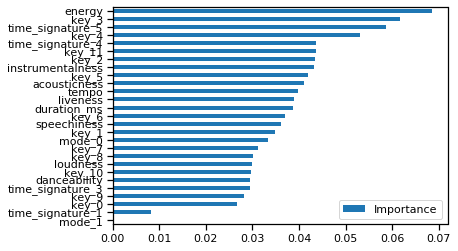

Random Forest RMSE with 11104 training data points: 0.1687388551363693
Random Forest CPU Time: 44.770564794540405 seconds



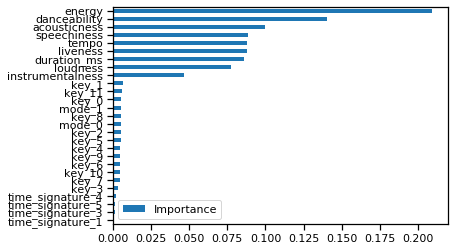

Epoch 1/150
178/178 - 1s - loss: 0.1182 - val_loss: 0.0698 - 840ms/epoch - 5ms/step
Epoch 2/150
178/178 - 0s - loss: 0.0576 - val_loss: 0.0526 - 261ms/epoch - 1ms/step
Epoch 3/150
178/178 - 0s - loss: 0.0473 - val_loss: 0.0453 - 248ms/epoch - 1ms/step
Epoch 4/150
178/178 - 0s - loss: 0.0425 - val_loss: 0.0450 - 247ms/epoch - 1ms/step
Epoch 5/150
178/178 - 0s - loss: 0.0402 - val_loss: 0.0407 - 249ms/epoch - 1ms/step
Epoch 6/150
178/178 - 0s - loss: 0.0383 - val_loss: 0.0384 - 254ms/epoch - 1ms/step
Epoch 7/150
178/178 - 0s - loss: 0.0374 - val_loss: 0.0384 - 246ms/epoch - 1ms/step
Epoch 8/150
178/178 - 0s - loss: 0.0367 - val_loss: 0.0374 - 250ms/epoch - 1ms/step
Epoch 9/150
178/178 - 0s - loss: 0.0363 - val_loss: 0.0378 - 245ms/epoch - 1ms/step
Epoch 10/150
178/178 - 0s - loss: 0.0357 - val_loss: 0.0373 - 250ms/epoch - 1ms/step
Epoch 11/150
178/178 - 0s - loss: 0.0352 - val_loss: 0.0362 - 249ms/epoch - 1ms/step
Epoch 12/150
178/178 - 0s - loss: 0.0349 - val_loss: 0.0370 - 251ms/epoch 

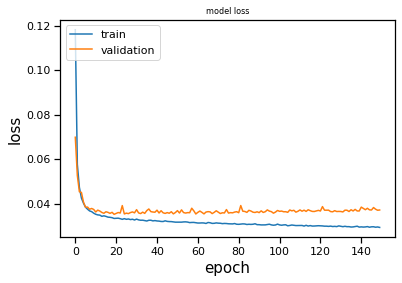

Neural Network RMSE with 11104 training data points: 0.19274798971710125
Neural Network CPU Time: 39.82304382324219 seconds



In [95]:
models = regression(df_ml, LINREG=True, RIDGE=True, LASSO=True, SVMR=True, XGB=True, RF=True, NN=True)

In [97]:
# Comparing histograms of predictions
def compare_predictions(pred_1, pred_2):
    bins = np.histogram(np.hstack((pred_1, pred_2)), bins=100)[1] #get the bin edges
    plt.hist(pred_1, bins=bins, alpha=1)
    plt.hist(pred_2, bins=bins, alpha=0.7)
    plt.title("Actual vs Predictions")
    plt.xlabel("Valence")
    plt.ylabel("Number of instances")
    plt.legend(["Actual", "Predictions"])
    plt.show()

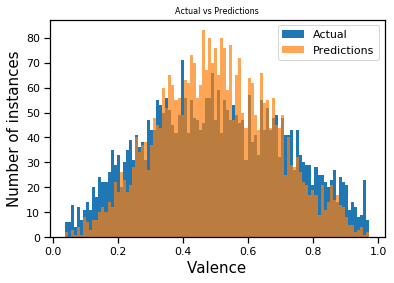

0.054823486989470316

In [98]:
# Predict Valence
xgb_model = models["XGBoost"]
test_pred = xgb_model.predict(X_test)
compare_predictions(y_test, test_pred)
mean_absolute_error(y_test, test_pred)

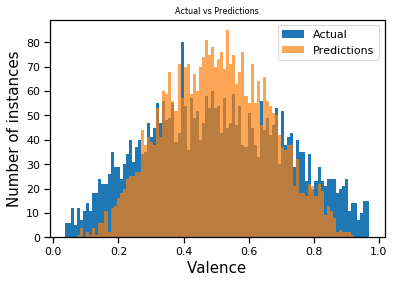

0.06516133192466037

In [99]:
# Predict Valence
rf = models['Random Forest']
test_pred = rf.predict(X_test)
compare_predictions(y_test, test_pred)
mean_absolute_error(y_test, test_pred)

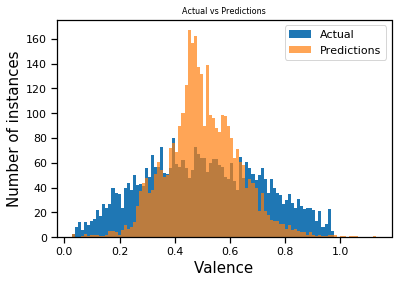

0.1422065567282641

In [100]:
# Predict Valence
nn = models['Neural Network']
test_pred = nn.predict(X_test).reshape(1,-1)[0]
compare_predictions(y_test, test_pred)
mean_absolute_error(y_test, test_pred)

In [101]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dvalid = xgb.DMatrix(X_test, label=y_test)
# dtest = xgb.DMatrix(test[feature_names].values)
watchlist = [(dtrain, 'train'), (dvalid, 'valid')]

In [108]:
# small: min_child_weight, eta
# large: subsample
xgb_pars = []
for MCW in [10, 20, 50, 75, 100]:
    for ETA in [0.05, 0.1, 0.15]:
        for CS in [0.3, 0.4, 0.5]:
            for MD in [6, 8, 10, 12, 15]:
                for SS in [0.5, 0.6, 0.7, 0.8, 0.9]:
                    for LAMBDA in [0.5, 1., 1.5,  2., 3.]:
                        xgb_pars.append({'min_child_weight': MCW, 'eta': ETA, 
                                         'colsample_bytree': CS, 'max_depth': MD,
                                         'subsample': SS, 'lambda': LAMBDA, 
                                         'nthread': -1, 'booster' : 'gbtree', 'eval_metric': 'rmse',
                                         'silent': 1, 'objective': 'reg:linear'})
top_score = 1 
for _ in range(50):
    xgb_par = np.random.choice(xgb_pars, 1)[0]
    print(xgb_par)
    model = xgb.train(xgb_par, dtrain, 2000, watchlist, early_stopping_rounds=50,
                      maximize=False, verbose_eval=100)
    print('Modeling RMSLE %.5f' % model.best_score)
    if model.best_score < top_score:
        top_score = model.best_score

print(f"Top score is: {top_score}")

{'min_child_weight': 50, 'eta': 0.1, 'colsample_bytree': 0.5, 'max_depth': 12, 'subsample': 0.8, 'lambda': 3.0, 'nthread': -1, 'booster': 'gbtree', 'eval_metric': 'rmse', 'silent': 1, 'objective': 'reg:linear'}
[19:56:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[19:56:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-rmse:0.20981	valid-rmse:0.21104
[100]	train-rmse:0.12492	valid-rmse:0.17340
[200]	train-rmse:0.10518	valid-rmse:0.17287
[251]	train-rmse:0.09666	valid-rmse:0.17290
Modeling RMSLE 0.17281
{'min_child_weight': 100, 'eta'

In [120]:
xgb_pars = {'min_child_weight': 10, 'eta': 0.05, 'colsample_bytree': 0.5, 'max_depth': 15, 'subsample': 0.8, 
'lambda': 2.0, 'nthread': -1, 'booster': 'gbtree', 'eval_metric': 'rmse', 'silent': 1, 'objective': 'reg:squarederror'}


model = xgb.train(xgb_pars, dtrain, 2000, watchlist, early_stopping_rounds=50,
                  maximize=False, verbose_eval=100)

[20:10:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-rmse:0.21073	valid-rmse:0.21270
[100]	train-rmse:0.07823	valid-rmse:0.17085
[200]	train-rmse:0.05155	valid-rmse:0.16834
[300]	train-rmse:0.03659	valid-rmse:0.16781
[400]	train-rmse:0.02677	valid-rmse:0.16759
[500]	train-rmse:0.01966	valid-rmse:0.16758
[523]	train-rmse:0.01852	valid-rmse:0.16758


In [111]:
print('Modeling RMSLE %.5f' % model.best_score)

Modeling RMSLE 0.16758


In [121]:
xgb_model = XGBRegressor(**xgb_pars)
xgb_model.fit(X_train, y_train)
pred_xgb = xgb_model.predict(X_test)

[20:11:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




In [124]:
from sklearn.model_selection import cross_val_score


scores = cross_val_score(xgb_model, X_train, y_train, scoring="neg_mean_absolute_error", cv=5)
print(-scores)
print(np.mean(-scores))

[20:13:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[20:13:15] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[20:13:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings bu

In [158]:
test_id = []
for playlist in ['5S8SJdl1BDc0ugpkEvFsIL', '37i9dQZF1DXcBWIGoYBM5M', '37i9dQZEVXbMDoHDwVN2tF', '2LOxEzC4KmoWJ9NhW0kz5M', 
                '5Rrf7mqN8uus2AaQQQNdc1', '6G9mBCSozMx0sOSXhSzZRY', '37i9dQZF1DWYJ5kmTbkZiz', '37i9dQZF1DWXRqgorJj26U']:
    for item in sp.playlist(playlist)['tracks']['items']:
        if item['track']['id'] not in all_track_ids + test_id:
            test_id.append(item['track']['id'])
len(test_id) 
 
features_test = {}
start = 0
num_tracks = 100
while start < len(test_id):
    print(f'getting from {start} to {start+num_tracks}')
    tracks_batch = test_id[start:start+num_tracks]
    features_batch = sp.audio_features(tracks_batch)
    features_test.update({ track_id : track_features 
                     for track_id, track_features in zip(tracks_batch, features_batch) })
    start += num_tracks          


getting from 0 to 100
getting from 100 to 200
getting from 200 to 300
getting from 300 to 400
getting from 400 to 500
getting from 500 to 600


In [159]:
test_df = pd.DataFrame.from_dict(features_test, orient='index').reset_index().rename(columns={'index': 'song_id'})

In [160]:
test_df.to_csv('./test_df.csv')